## Diffusion Models: brief introduction

Diffusion models are a relatively recent addition to a group of algorithms known as `generative models`. The diffusion's generation process begins with random noise, but this is gradually refined over a number of steps until an output image emerges. At each step, the model estimates how we could go from the current input to a completely denoised version.

<p align="center">
    <img src="https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png" width="800"/>
    <br>
    <em> Figure from DDPM paper (https://arxiv.org/abs/2006.11239). </em>
<p>

Training process of the diffusion model is conducted repeatedly and consists of following steps:

  1. Load images from the training data
  2. Curruption process (add noise)
  3. Feed the noisy versions of the inputs into the model
  4. Evaluate how well the model does at denoising these inputs
  5. Use this information to update the model weights

To generate new images with a trained model, we begin with a completely random input and repeatedly feed it through the model, updating it each time by a small amount based on the model prediction.  

### Setup and Imports

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [2]:
#!pip freeze > requirements.txt

### Load data

To speed up the learning process, we are going to use a small dataset - MNIST.

In [3]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 58789350.71it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112058921.21it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32613821.94it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23317660.67it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



### The corruption process

We need to add noise to input images, then feed the noisy images to the model. The DDPM paper describes a corruption process that gradually adds a small amount of noise. Let us implement the simplified version of this approach:

In [4]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1)
  return x * (1-amount) + noise * amount

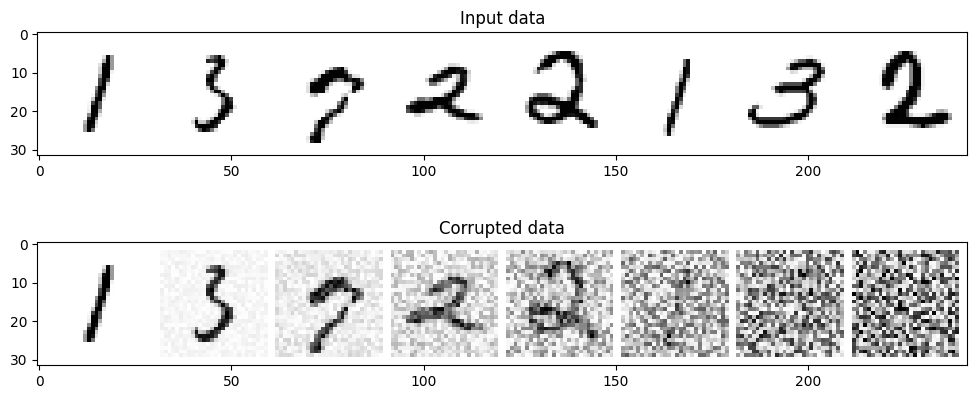

In [5]:
# Plotting the input data
x, y = next(iter(train_dataloader))
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

## The Model

We need a model that takes noisy images as an input and outputs a prediction of the same shape. We can use UNet for this purpose.

In [6]:
class UNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x

## Training the network

Given a corrupted input noisy_x the model should output its best guess for what the original x looks like. Mean squared error will be used as the loss function.

In [15]:
def train_ddpm(dataset, batch_size, n_epochs, device):

  # Dataloader
  train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  # Create the network
  net = UNet()
  net.to(device)

  # Our loss function
  loss_fn = nn.MSELoss()

  # The optimizer
  opt = torch.optim.Adam(net.parameters(), lr=1e-3)

  # Keeping a record of the losses for later viewing
  losses = []

  # The training loop
  for epoch in tqdm(range(n_epochs)):

      for x, y in train_dataloader:

          # Get some data and prepare the corrupted version
          x = x.to(device) # Data on the GPU
          noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
          noisy_x = corrupt(x, noise_amount) # Create our noisy x

          # Get the model prediction
          pred = net(noisy_x)

          # Calculate the loss
          loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

          # Backprop and update the params:
          opt.zero_grad()
          loss.backward()
          opt.step()

          # Store the loss for later
          losses.append(loss.item())

      # Print our the average of the loss values for this epoch:
      avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
      print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

  # View the loss curve
  plt.plot(losses)
  plt.ylim(0, 0.1);
  return net

  1%|          | 1/100 [00:11<18:48, 11.40s/it]

Finished epoch 0. Average loss for this epoch: 0.026179


  2%|▏         | 2/100 [00:22<18:28, 11.31s/it]

Finished epoch 1. Average loss for this epoch: 0.020009


  3%|▎         | 3/100 [00:33<18:16, 11.30s/it]

Finished epoch 2. Average loss for this epoch: 0.018348


  4%|▍         | 4/100 [00:44<17:53, 11.18s/it]

Finished epoch 3. Average loss for this epoch: 0.017569


  5%|▌         | 5/100 [00:55<17:35, 11.11s/it]

Finished epoch 4. Average loss for this epoch: 0.017085


  6%|▌         | 6/100 [01:06<17:20, 11.07s/it]

Finished epoch 5. Average loss for this epoch: 0.016633


  7%|▋         | 7/100 [01:19<17:41, 11.41s/it]

Finished epoch 6. Average loss for this epoch: 0.016543


  8%|▊         | 8/100 [01:29<17:15, 11.26s/it]

Finished epoch 7. Average loss for this epoch: 0.016183


  9%|▉         | 9/100 [01:40<16:51, 11.12s/it]

Finished epoch 8. Average loss for this epoch: 0.016072


 10%|█         | 10/100 [01:51<16:34, 11.05s/it]

Finished epoch 9. Average loss for this epoch: 0.015970


 11%|█         | 11/100 [02:02<16:18, 11.00s/it]

Finished epoch 10. Average loss for this epoch: 0.015775


 12%|█▏        | 12/100 [02:13<16:05, 10.97s/it]

Finished epoch 11. Average loss for this epoch: 0.015363


 13%|█▎        | 13/100 [02:24<15:51, 10.94s/it]

Finished epoch 12. Average loss for this epoch: 0.015158


 14%|█▍        | 14/100 [02:35<15:38, 10.91s/it]

Finished epoch 13. Average loss for this epoch: 0.014710


 15%|█▌        | 15/100 [02:45<15:23, 10.86s/it]

Finished epoch 14. Average loss for this epoch: 0.014232


 16%|█▌        | 16/100 [02:56<15:05, 10.78s/it]

Finished epoch 15. Average loss for this epoch: 0.013968


 17%|█▋        | 17/100 [03:07<14:53, 10.77s/it]

Finished epoch 16. Average loss for this epoch: 0.013913


 18%|█▊        | 18/100 [03:18<14:42, 10.77s/it]

Finished epoch 17. Average loss for this epoch: 0.013665


 19%|█▉        | 19/100 [03:28<14:36, 10.82s/it]

Finished epoch 18. Average loss for this epoch: 0.013509


 20%|██        | 20/100 [03:39<14:25, 10.82s/it]

Finished epoch 19. Average loss for this epoch: 0.013431


 21%|██        | 21/100 [03:50<14:14, 10.82s/it]

Finished epoch 20. Average loss for this epoch: 0.013225


 22%|██▏       | 22/100 [04:01<14:03, 10.81s/it]

Finished epoch 21. Average loss for this epoch: 0.013156


 23%|██▎       | 23/100 [04:12<13:49, 10.78s/it]

Finished epoch 22. Average loss for this epoch: 0.013106


 24%|██▍       | 24/100 [04:22<13:37, 10.76s/it]

Finished epoch 23. Average loss for this epoch: 0.012976


 25%|██▌       | 25/100 [04:33<13:20, 10.67s/it]

Finished epoch 24. Average loss for this epoch: 0.012741


 26%|██▌       | 26/100 [04:43<13:06, 10.63s/it]

Finished epoch 25. Average loss for this epoch: 0.012665


 27%|██▋       | 27/100 [04:54<12:59, 10.67s/it]

Finished epoch 26. Average loss for this epoch: 0.012790


 28%|██▊       | 28/100 [05:05<12:50, 10.71s/it]

Finished epoch 27. Average loss for this epoch: 0.012710


 29%|██▉       | 29/100 [05:16<12:39, 10.70s/it]

Finished epoch 28. Average loss for this epoch: 0.012589


 30%|███       | 30/100 [05:26<12:30, 10.72s/it]

Finished epoch 29. Average loss for this epoch: 0.012508


 31%|███       | 31/100 [05:37<12:19, 10.72s/it]

Finished epoch 30. Average loss for this epoch: 0.012464


 32%|███▏      | 32/100 [05:48<12:07, 10.69s/it]

Finished epoch 31. Average loss for this epoch: 0.012539


 33%|███▎      | 33/100 [05:58<11:54, 10.66s/it]

Finished epoch 32. Average loss for this epoch: 0.012331


 34%|███▍      | 34/100 [06:08<11:35, 10.54s/it]

Finished epoch 33. Average loss for this epoch: 0.012383


 35%|███▌      | 35/100 [06:19<11:22, 10.51s/it]

Finished epoch 34. Average loss for this epoch: 0.012135


 36%|███▌      | 36/100 [06:30<11:14, 10.54s/it]

Finished epoch 35. Average loss for this epoch: 0.012289


 37%|███▋      | 37/100 [06:40<11:03, 10.54s/it]

Finished epoch 36. Average loss for this epoch: 0.012130


 38%|███▊      | 38/100 [06:51<10:53, 10.53s/it]

Finished epoch 37. Average loss for this epoch: 0.012226


 39%|███▉      | 39/100 [07:01<10:43, 10.55s/it]

Finished epoch 38. Average loss for this epoch: 0.012135


 40%|████      | 40/100 [07:12<10:31, 10.53s/it]

Finished epoch 39. Average loss for this epoch: 0.012197


 41%|████      | 41/100 [07:22<10:21, 10.53s/it]

Finished epoch 40. Average loss for this epoch: 0.012208


 42%|████▏     | 42/100 [07:33<10:08, 10.49s/it]

Finished epoch 41. Average loss for this epoch: 0.012133


 43%|████▎     | 43/100 [07:43<09:54, 10.43s/it]

Finished epoch 42. Average loss for this epoch: 0.012047


 44%|████▍     | 44/100 [07:53<09:46, 10.47s/it]

Finished epoch 43. Average loss for this epoch: 0.011976


 45%|████▌     | 45/100 [08:04<09:37, 10.50s/it]

Finished epoch 44. Average loss for this epoch: 0.012004


 46%|████▌     | 46/100 [08:15<09:27, 10.50s/it]

Finished epoch 45. Average loss for this epoch: 0.012098


 47%|████▋     | 47/100 [08:25<09:16, 10.50s/it]

Finished epoch 46. Average loss for this epoch: 0.012038


 48%|████▊     | 48/100 [08:36<09:06, 10.52s/it]

Finished epoch 47. Average loss for this epoch: 0.011895


 49%|████▉     | 49/100 [08:46<08:56, 10.52s/it]

Finished epoch 48. Average loss for this epoch: 0.011883


 50%|█████     | 50/100 [08:57<08:48, 10.56s/it]

Finished epoch 49. Average loss for this epoch: 0.011966


 51%|█████     | 51/100 [09:07<08:31, 10.44s/it]

Finished epoch 50. Average loss for this epoch: 0.011780


 52%|█████▏    | 52/100 [09:17<08:21, 10.45s/it]

Finished epoch 51. Average loss for this epoch: 0.011939


 53%|█████▎    | 53/100 [09:28<08:12, 10.47s/it]

Finished epoch 52. Average loss for this epoch: 0.011777


 54%|█████▍    | 54/100 [09:39<08:03, 10.52s/it]

Finished epoch 53. Average loss for this epoch: 0.011891


 55%|█████▌    | 55/100 [09:49<07:53, 10.53s/it]

Finished epoch 54. Average loss for this epoch: 0.011988


 56%|█████▌    | 56/100 [10:00<07:43, 10.53s/it]

Finished epoch 55. Average loss for this epoch: 0.011760


 57%|█████▋    | 57/100 [10:10<07:33, 10.55s/it]

Finished epoch 56. Average loss for this epoch: 0.011834


 58%|█████▊    | 58/100 [10:21<07:23, 10.56s/it]

Finished epoch 57. Average loss for this epoch: 0.011705


 59%|█████▉    | 59/100 [10:31<07:07, 10.43s/it]

Finished epoch 58. Average loss for this epoch: 0.011748


 60%|██████    | 60/100 [10:41<06:57, 10.45s/it]

Finished epoch 59. Average loss for this epoch: 0.011767


 61%|██████    | 61/100 [10:52<06:48, 10.47s/it]

Finished epoch 60. Average loss for this epoch: 0.011862


 62%|██████▏   | 62/100 [11:02<06:38, 10.48s/it]

Finished epoch 61. Average loss for this epoch: 0.011734


 63%|██████▎   | 63/100 [11:13<06:30, 10.54s/it]

Finished epoch 62. Average loss for this epoch: 0.011703


 64%|██████▍   | 64/100 [11:24<06:20, 10.57s/it]

Finished epoch 63. Average loss for this epoch: 0.011802


 65%|██████▌   | 65/100 [11:35<06:11, 10.62s/it]

Finished epoch 64. Average loss for this epoch: 0.011686


 66%|██████▌   | 66/100 [11:45<06:01, 10.63s/it]

Finished epoch 65. Average loss for this epoch: 0.011691


 67%|██████▋   | 67/100 [11:56<05:50, 10.61s/it]

Finished epoch 66. Average loss for this epoch: 0.011656


 68%|██████▊   | 68/100 [12:06<05:38, 10.57s/it]

Finished epoch 67. Average loss for this epoch: 0.011722


 69%|██████▉   | 69/100 [12:17<05:28, 10.61s/it]

Finished epoch 68. Average loss for this epoch: 0.011814


 70%|███████   | 70/100 [12:28<05:19, 10.66s/it]

Finished epoch 69. Average loss for this epoch: 0.011644


 71%|███████   | 71/100 [12:39<05:10, 10.72s/it]

Finished epoch 70. Average loss for this epoch: 0.011616


 72%|███████▏  | 72/100 [12:49<05:02, 10.79s/it]

Finished epoch 71. Average loss for this epoch: 0.011718


 73%|███████▎  | 73/100 [13:00<04:52, 10.82s/it]

Finished epoch 72. Average loss for this epoch: 0.011530


 74%|███████▍  | 74/100 [13:11<04:42, 10.86s/it]

Finished epoch 73. Average loss for this epoch: 0.011660


 75%|███████▌  | 75/100 [13:22<04:30, 10.83s/it]

Finished epoch 74. Average loss for this epoch: 0.011516


 76%|███████▌  | 76/100 [13:33<04:19, 10.82s/it]

Finished epoch 75. Average loss for this epoch: 0.011602


 77%|███████▋  | 77/100 [13:43<04:06, 10.72s/it]

Finished epoch 76. Average loss for this epoch: 0.011615


 78%|███████▊  | 78/100 [13:54<03:55, 10.72s/it]

Finished epoch 77. Average loss for this epoch: 0.011627


 79%|███████▉  | 79/100 [14:05<03:46, 10.77s/it]

Finished epoch 78. Average loss for this epoch: 0.011563


 80%|████████  | 80/100 [14:16<03:37, 10.90s/it]

Finished epoch 79. Average loss for this epoch: 0.011605


 81%|████████  | 81/100 [14:27<03:27, 10.94s/it]

Finished epoch 80. Average loss for this epoch: 0.011634


 82%|████████▏ | 82/100 [14:38<03:17, 10.96s/it]

Finished epoch 81. Average loss for this epoch: 0.011625


 83%|████████▎ | 83/100 [14:49<03:06, 10.98s/it]

Finished epoch 82. Average loss for this epoch: 0.011632


 84%|████████▍ | 84/100 [15:00<02:55, 10.99s/it]

Finished epoch 83. Average loss for this epoch: 0.011630


 85%|████████▌ | 85/100 [15:11<02:44, 10.98s/it]

Finished epoch 84. Average loss for this epoch: 0.011543


 86%|████████▌ | 86/100 [15:22<02:33, 10.98s/it]

Finished epoch 85. Average loss for this epoch: 0.011664


 87%|████████▋ | 87/100 [15:33<02:22, 10.95s/it]

Finished epoch 86. Average loss for this epoch: 0.011581


 88%|████████▊ | 88/100 [15:44<02:10, 10.86s/it]

Finished epoch 87. Average loss for this epoch: 0.011522


 89%|████████▉ | 89/100 [15:54<01:59, 10.83s/it]

Finished epoch 88. Average loss for this epoch: 0.011524


 90%|█████████ | 90/100 [16:05<01:48, 10.87s/it]

Finished epoch 89. Average loss for this epoch: 0.011567


 91%|█████████ | 91/100 [16:16<01:37, 10.87s/it]

Finished epoch 90. Average loss for this epoch: 0.011468


 92%|█████████▏| 92/100 [16:27<01:27, 10.88s/it]

Finished epoch 91. Average loss for this epoch: 0.011572


 93%|█████████▎| 93/100 [16:38<01:16, 10.91s/it]

Finished epoch 92. Average loss for this epoch: 0.011603


 94%|█████████▍| 94/100 [16:49<01:05, 10.89s/it]

Finished epoch 93. Average loss for this epoch: 0.011445


 95%|█████████▌| 95/100 [17:00<00:54, 10.90s/it]

Finished epoch 94. Average loss for this epoch: 0.011479


 96%|█████████▌| 96/100 [17:11<00:43, 10.90s/it]

Finished epoch 95. Average loss for this epoch: 0.011512


 97%|█████████▋| 97/100 [17:22<00:32, 10.86s/it]

Finished epoch 96. Average loss for this epoch: 0.011458


 98%|█████████▊| 98/100 [17:32<00:21, 10.84s/it]

Finished epoch 97. Average loss for this epoch: 0.011566


 99%|█████████▉| 99/100 [17:43<00:10, 10.87s/it]

Finished epoch 98. Average loss for this epoch: 0.011431


100%|██████████| 100/100 [17:55<00:00, 10.75s/it]

Finished epoch 99. Average loss for this epoch: 0.011468


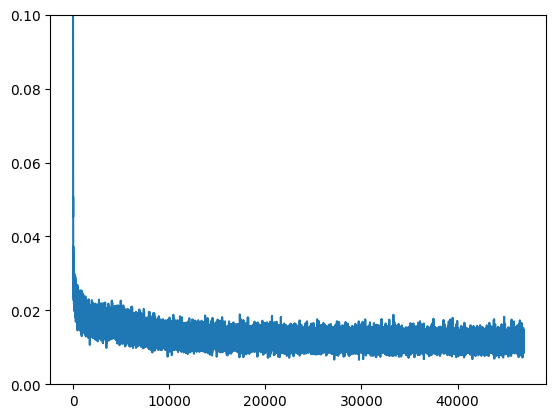

In [16]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
batch_size = 128
n_epochs = 100
net = train_ddpm(dataset, batch_size, n_epochs, device)

### Sampling

Strarting from random noise, the model makes a prediction, but then we onlu take a tiny step towards that prediction. The hope is that this new prediction is slightly better than the first one and we can take another small step with this new, better prediction.

Let's illustrate this process with the small number of steps:

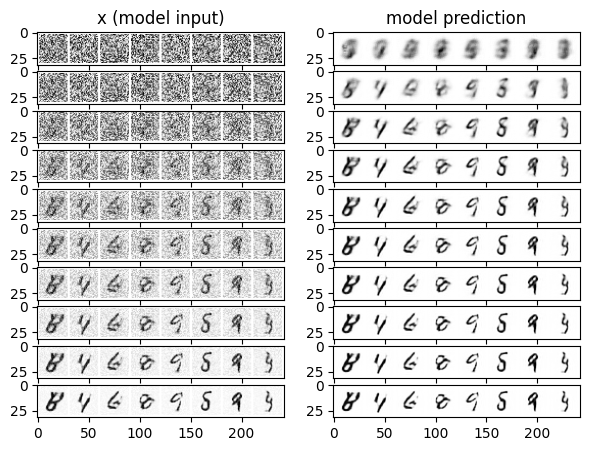

In [20]:
# Break the process into n steps and move 1/n'th of the way there each time:
n_steps = 10
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(7, 5), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

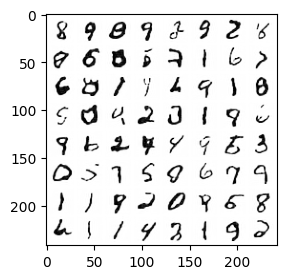

In [52]:
# Generate more results
n_steps = 500
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i / n_steps))
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1 / (n_steps - i)
  x = x * (1 - mix_factor) + pred * mix_factor
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

This was rather simplified realisation, but it illustrates the main idea of the method proposed in the paper. And still it can produce fairly recognizable digits. The final result is not perfect, but the computational limitations must be taken into account. To achieve a better result, number of epochs can be increased, as well as the number of steps in the generation process.